In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow

In [2]:
!pip install tensorflow

In [57]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
#Loading data
data = pd.read_csv('Microsoft Corporationstock.csv')

In [7]:
#examining our dataset
data.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company
0,2001-01-24,31.71875,30.37500,30.50000,31.46875,110455000.0,20.033434,Microsoft Corporation
1,2001-01-25,32.00000,30.78125,31.37500,30.90625,85657400.0,19.675337,Microsoft Corporation
2,2001-01-26,32.15625,30.50000,30.50000,32.00000,93080000.0,20.371634,Microsoft Corporation
3,2001-01-29,32.31250,31.75000,31.78125,32.25000,84983800.0,20.530788,Microsoft Corporation
4,2001-01-30,32.37500,31.43750,32.25000,31.68750,57276800.0,20.172686,Microsoft Corporation


# Preprocessing

In [8]:
#checking datatypes
print(data.dtypes)

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
Company       object
dtype: object


In [9]:
#=Converting 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [10]:
#rechecking datatypes
print(data.dtypes)

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
Company              object
dtype: object


In [11]:
#sorting the data by date
data.sort_values('Date', inplace=True)

In [12]:
#Checking for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
Company      0
dtype: int64


In [27]:
#identifying numerical columns
num_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
numerical_data = data[num_cols]

#Define threshold for considering outliers
threshold = 10  #how much they deviate from the mean!

outlier_indices = []
for col in num_cols:
    z_scores = stats.zscore(data[col])
    column_outliers = np.where(np.abs(z_scores) > threshold)[0]
    outlier_indices.extend(column_outliers)

#Remove duplicates from outlier indices
outlier_indices = list(set(outlier_indices))

#Display indices of outliers
print("Indices of Outliers:")
print(outlier_indices)

Indices of Outliers:
[1321]


In [28]:
#Remove outliers
data = data.drop(outlier_indices)

#Display the shape of the cleaned dataset
print("Shape of Cleaned Dataset:", data.shape)

Shape of Cleaned Dataset: (5030, 8)


In [29]:
#Normalizing numerical columns using MinMaxScaler
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

#Model

In [32]:
#prediction horizon
prediction_horizon = 1

#Shiftting Close prices to obtain labels
data['Label'] = data['Close'].shift(-prediction_horizon)

In [42]:
#Checking for NaN values in each column
nan_check = data.isnull().any()
print("Columns with NaN values:")
print(nan_check[nan_check == True])

Columns with NaN values:
Label    True
dtype: bool


In [43]:
#Remove rows with NaN values in the 'Label' column
data = data.dropna(subset=['Label'])

#Verify that NaN values have been removed
nan_check = data.isnull().any()
print("Columns with NaN values after removal:")
print(nan_check[nan_check == True])

Columns with NaN values after removal:
Series([], dtype: bool)


In [44]:
#Splitting data into training and testing sets (80% training,20%testing)
#features (X) and labels (y)
X = data[['High', 'Low', 'Open', 'Volume', 'Adj Close']].values
y = data['Label'].values
#Splitting data into training and testing sets (80% training,20%testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [53]:
#LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))

In [54]:
#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
#training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
126/126 [==============================] - 4s 14ms/step - loss: 0.0075 - val_loss: 4.7892e-04
Epoch 2/100
126/126 [==============================] - 1s 6ms/step - loss: 3.8601e-04 - val_loss: 3.5975e-04
Epoch 3/100
126/126 [==============================] - 1s 6ms/step - loss: 2.9659e-04 - val_loss: 2.9992e-04
Epoch 4/100
126/126 [==============================] - 1s 6ms/step - loss: 2.6233e-04 - val_loss: 2.5953e-04
Epoch 5/100
126/126 [==============================] - 1s 10ms/step - loss: 2.3290e-04 - val_loss: 2.3188e-04
Epoch 6/100
126/126 [==============================] - 1s 9ms/step - loss: 2.0097e-04 - val_loss: 1.9573e-04
Epoch 7/100
126/126 [==============================] - 1s 10ms/step - loss: 1.8121e-04 - val_loss: 1.7542e-04
Epoch 8/100
126/126 [==============================] - 1s 7ms/step - loss: 1.5414e-04 - val_loss: 1.3518e-04
Epoch 9/100
126/126 [==============================] - 1s 6ms/step - loss: 1.3129e-04 - val_loss: 1.3377e-04
Epoch 10/100
126/126

In [58]:
#making predictions
predictions = model.predict(X_test)

32/32 [==============================] - 1s 3ms/step


In [60]:
#calculating rmse
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


Given that the target values (y array) are normalized and range between 0 and 1, an RMSE of 0.007 is quite good. This means that on average, the model's predictions are within 0.007 of the actual stock prices, which is a small error given the range of your target variable.

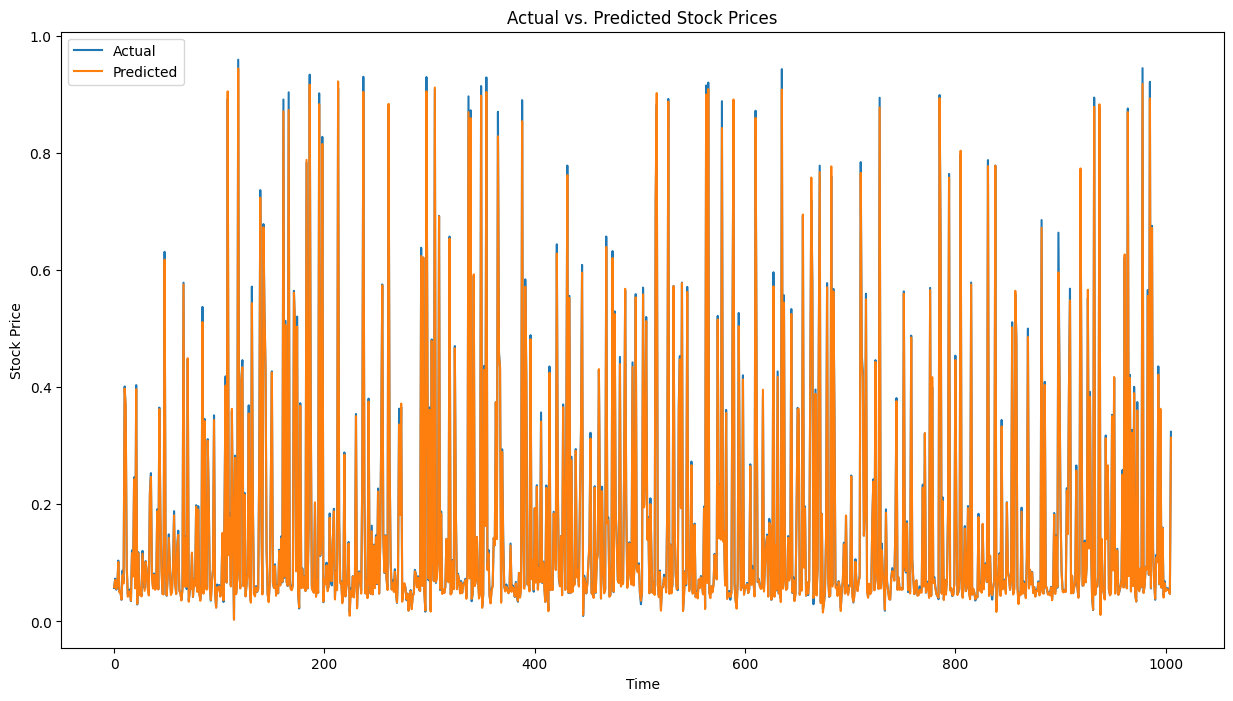

In [67]:
#Plotting actual vs. predicted values for visualization
plt.figure(figsize=(15, 8))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()